In [34]:
from androguard.misc import AnalyzeAPK, Analysis
from androguard.core.analysis.analysis import StringAnalysis
import os
import pandas as pd
from dotenv import dotenv_values
import numpy as np

## Utility Functions

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from math import floor, log10
from collections import Counter

benford = pd.DataFrame(
    {
        'digit': [1, 2, 3, 4, 5, 6, 7, 8, 9],
        'freq': [.301, .176, .125, .097, .079, .067, .058, .051, .046]
    })

def get_first_digit(i: int):
    if i == 0:
        return 0
    return floor(i / (10 ** floor(log10(i))))

def score_distance(df1, df2):
    df = pd.merge(df1, df2, on='digit', suffixes=['1', '2'])
    df['distance'] = abs(df['freq1'] - df['freq2'])
    return round(df['distance'].mean(), 4)

def data_to_df(data: list[int]):
    # Take list of data points and return dataframe of first digit frequencies as percentages
    fd = [get_first_digit(d) for d in data]
    df = pd.DataFrame(Counter(fd).items(), columns=['digit', 'freq'])
    df = df[df['digit'] != 0]
    total = df['freq'].sum()
    df['freq'] = df['freq'].astype(float)
    df['freq'] /= total
    return df.copy()

def graph(data: list[int], title=""):
    df = data_to_df(data).copy()

    fig, ax = plt.subplots()
    
    sns.lineplot(x=df['digit'], y=df['freq'], ax=ax, markers='o', markersize=6, label='Custom').set(xlabel='First Digit', ylabel="Frequency", title=title)
    sns.lineplot(x=benford['digit'], y=benford['freq'], ax=ax, label='Benford')
    ax.text(.8, .8, "Score: " + str(score_distance(df, benford)), transform=ax.transAxes)


## Lengths of constant strings

In [36]:
def graph_string_length(analysis):
    strings = analysis.get_strings()  # dex[0].get_strings()
    strings = list(map(StringAnalysis.get_value, strings))
    strings = list(map(str.strip, strings))

    data = list(map(len, strings))

    graph(data, "String length")

## Sum of Decimal encoded characters of constant strings

In [37]:
def sum_of_chars(s):
    return sum(ord(c) for c in s)

def graph_string_value(analysis):
    strings = analysis.get_strings()  # dex[0].get_strings()
    strings = list(map(StringAnalysis.get_value, strings))

    strings = list(map(str.strip, strings))

    data = list(map(sum_of_chars, strings))

    graph(data, "String value")

## Lengths of methods

In [38]:
def graph_method_lengths(analysis):
    methods = analysis.get_methods()

    # The above get_methods() method returns a deprecated type, so we get_method() again below to return a usable type.
    # External methods don't have available lengths, so we skip past them
    method_lengths = [method.get_method().get_length() for method in methods if not method.is_external()]

    graph(method_lengths, "Method Lengths")

## Number of fields in a class

In [39]:
def graph_class_fields(analysis):
    classes = analysis.get_internal_classes()

    fields = [c.get_fields() for c in classes]

    fields_count = map(len, fields)

    graph(fields_count, "Class Fields")

## Number of methods in a class

In [40]:
def graph_class_methods(analysis):
    classes = analysis.get_internal_classes()

    methods = [c.get_methods() for c in classes]

    methods_count = map(len, methods)

    graph(methods_count, "Class Methods")

## Bytes -> Hex -> Decimal of classes.dex file

In [44]:
def graph_classes_dex(apk):
    all_classes = apk.get_all_dex()

    byte = [int(c, 16) for classes in all_classes for c in classes.hex(sep=' ').split(' ')]

    graph(byte, "Classes Dex")

## Main Code

### Unpack Android APKs

In [42]:
# https://apkcombo.com/colornote/com.socialnmobile.dictapps.notepad.color.note/download/apk
test_apk = os.path.abspath('./APKs/color_note.apk')

apk,dex,analysis = AnalyzeAPK(test_apk)

Requested API level 31 is larger than maximum we have, returning API level 28 instead.


### Create Graphs

c:\Users\gschi\miniconda3\envs\onr-android-malware\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\gschi\miniconda3\envs\onr-android-malware\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\gschi\miniconda3\envs\onr-android-malware\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\gschi\miniconda3\envs\onr-android-malware\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

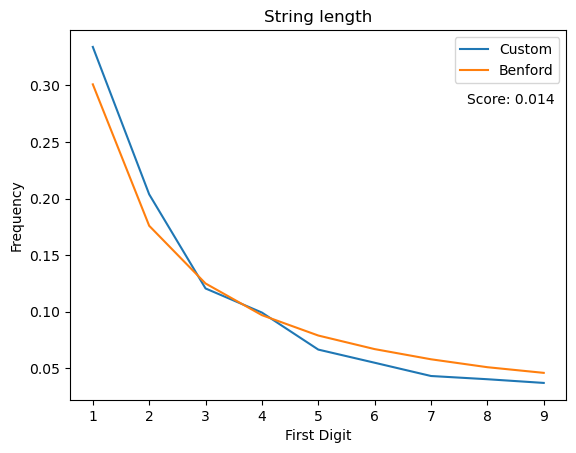

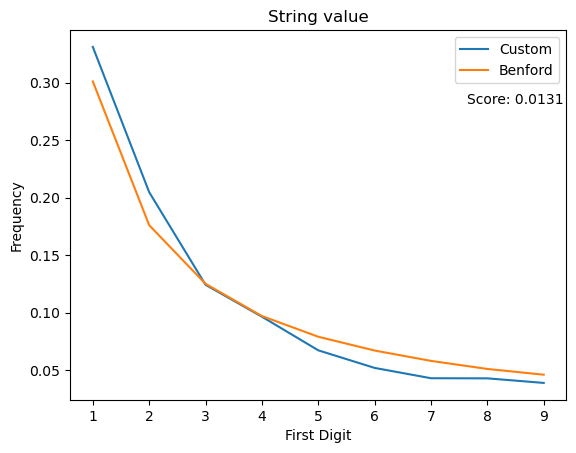

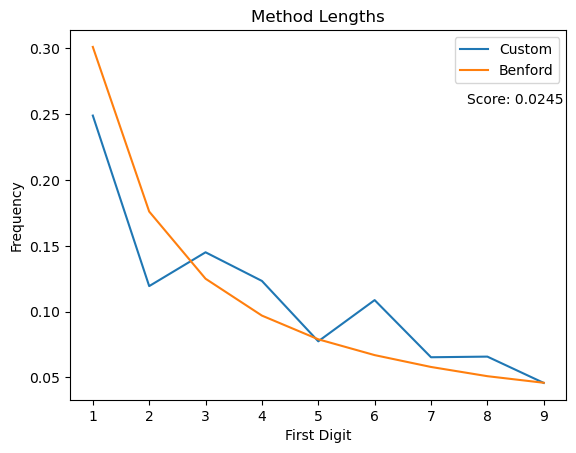

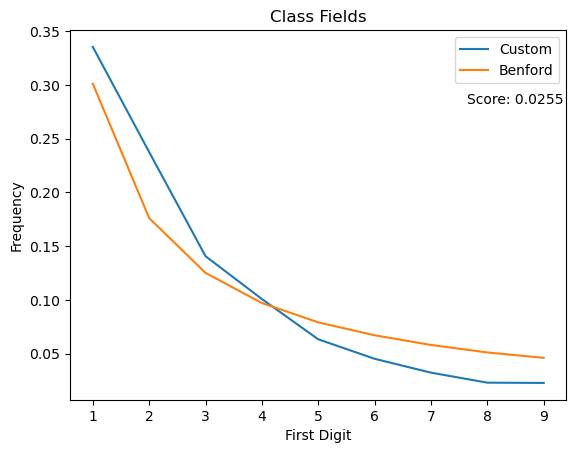

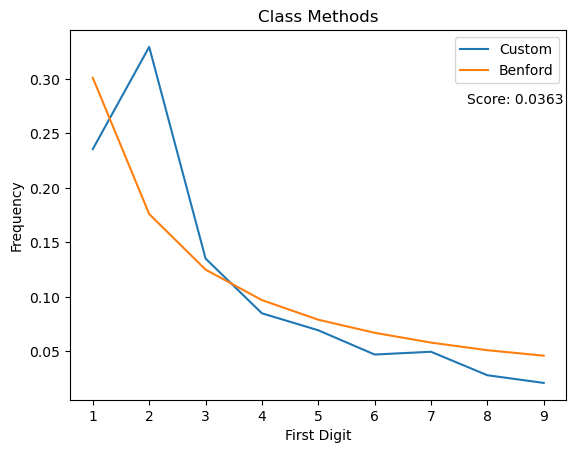

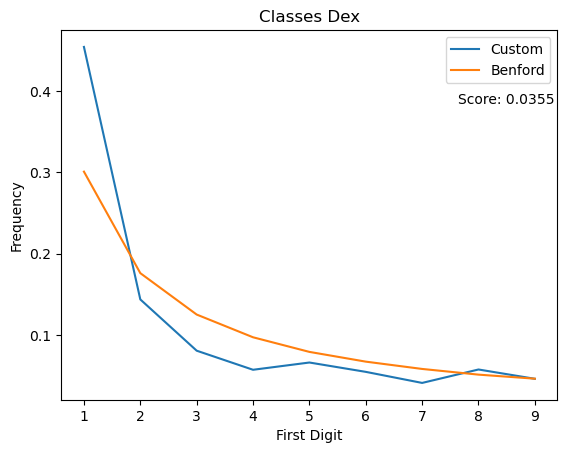

In [45]:
graph_string_length(analysis)
graph_string_value(analysis)
graph_method_lengths(analysis)
graph_class_fields(analysis)
graph_class_methods(analysis)
graph_classes_dex(apk)